In [ ]:
!pip install tensorflow

In [1]:
import os
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

In [ ]:
# define the discriminator model

def discriminator(image_shape):
    init = RandomNormal(stddev=0.02)  # weight initialization
    in_src_image = Input(shape=image_shape)  # source image as input
    in_target_image = Input(shape=image_shape) # target image as input
    merged = Concatenate()([in_src_image, in_target_image])  # concatenate images channel-wise

    # define architecture
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), padding="same", kernel_initializer=init)(d)  # second last output layer
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(1, (4,4), padding="same", kernel_initializer=init)(d)  # patch output
    patch_out = Activation("sigmoid")(d)

    model = Model([in_src_image, in_target_image], patch_out)  # define model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)  # compile model
    
    model.compile(loss="binary_crossentropy", optimizer=opt, loss_weights=[0.5])
    return model

In [ ]:
# define an encoder block

def encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)  # weight initialization
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(layer_in)  # add downsampling layer
    
    if batchnorm:
        g = BatchNormalization()(g, training=True)  # conditionally add batch normalization
    
    g = LeakyReLU(alpha=0.2)(g)  # leaky relu activation
    return g

In [ ]:
# define a decoder block

def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)  # weight initialization
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(layer_in)  # add upsampling layer
    g = BatchNormalization()(g, training=True)  # add batch normalization
    
    if dropout:
        g = Dropout(0.5)(g, training=True)  # conditionally add dropout
    
    g = Concatenate()([g, skip_in])  # merge with skip connection
    
    g = Activation("relu")(g)  # relu activation
    return g

In [ ]:
# define the standalone generator model

def generator(image_shape=(256,256,3)):
    init = RandomNormal(stddev=0.02)  # weight initialization
    in_image = Input(shape=image_shape)  # image input
    
    # encoder model
    e1 = encoder_block(in_image, 64, batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)

    b = Conv2D(512, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(e7)  # no batch norm and relu
    b = Activation("relu")(b)

    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d7)
    out_image = Activation("tanh")(g)

    # define model
    model = Model(in_image, out_image)
    return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator

def gan(g_model, d_model, image_shape):
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False  # make weights in the discriminator not trainable
    
    in_src = Input(shape=image_shape)  # define the source image
    
    gen_out = g_model(in_src)  # connect the source image to the generator input
    
    dis_out = d_model([in_src, gen_out])  # connect the source input and generator output to the discriminator input
    
    model = Model(in_src, [dis_out, gen_out])  # src image as input, generated image and classification output
    
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=["binary_crossentropy", "mae"], optimizer=opt, loss_weights=[1,100])
    return model

In [ ]:
# load and prepare training images

def load_real_samples(filename):
    data = load(filename)  # load data
    X1, X2 = data["arr_0"], data["arr_1"]
    
    # [0, 255] -> [-1, 1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [ ]:
# select a batch of random samples, returns images and target

def generate_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
    ix = randint(0, trainA.shape[0], n_samples)  # choose random instances
    X1, X2 = trainA[ix], trainB[ix]
    
    y = ones((n_samples, patch_shape, patch_shape, 1))  # generate 'real' class labels = 1
    return [X1, X2], y

# generate a batch of images, returns images and targets

def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    
    y = zeros((len(X), patch_shape, patch_shape, 1))  # create 'fake' class labels = 0
    return X, y

In [ ]:
# generate samples and save as a plot and save the model

def summarize_performance(step, g_model, dataset, n_samples=3):
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)  # select a sample of input images
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)  # generate a batch of fake samples
    
    # [-1, 1] -> [0, 1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis("off")
        pyplot.imshow(X_realA[i])

    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis("off")
        pyplot.imshow(X_fakeB[i])

    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis("off")
        pyplot.imshow(X_realB[i])

    # save plot to file
    filename1 = "/content/drive/MyDrive/Strojno_projekt/models/plot_%06d.png" % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    
    # save the generator model
    filename2 = "/content/drive/MyDrive/Strojno_projekt/models/model_%06d.h5" % (step+1)
    g_model.save(filename2)
    print(">Saved: %s and %s" % (filename1, filename2))

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=50, n_batch=1):
    n_patch = d_model.output_shape[1]  # determine the output square shape of the discriminator
    trainA, trainB = dataset

    bat_per_epo = int(len(trainA) / n_batch)
    n_steps = bat_per_epo * n_epochs  # number of training iterations

    # enumerate epochs
    for i in range(n_steps):
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)  # select a batch of real samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)  # generate a batch of fake samples
        
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)  # update discriminator for real samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)  # update discriminator for generated samples
        
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])  # update the generator
        
        # summarize performance
        print(">%d, d1[%.3f] d2[%.3f] g[%.3f]" % (i+1, d_loss1, d_loss2, g_loss))
        
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load image data
path = "/content/drive/MyDrive/Strojno_projekt/dataset/maps/maps_256_train.npz"
dataset = load_real_samples(path)
print("Loaded", dataset[0].shape, dataset[1].shape)

# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

# define the models
disc_model = discriminator(image_shape)
gen_model = generator(image_shape)

# define the composite model
gan_model = gan(gen_model, disc_model, image_shape)

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


In [ ]:
# train model
train(disc_model, gen_model, gan_model, dataset)

Streaming output truncated to the last 5000 lines.
>49803, d1[0.323] d2[0.329] g[4.512]
>49804, d1[0.344] d2[0.398] g[5.029]
>49805, d1[0.278] d2[0.338] g[4.291]
>49806, d1[0.406] d2[0.280] g[5.329]
>49807, d1[0.259] d2[0.386] g[4.481]
>49808, d1[0.301] d2[0.329] g[4.715]
>49809, d1[0.354] d2[0.351] g[5.674]
>49810, d1[0.374] d2[0.405] g[4.243]
>49811, d1[0.385] d2[0.348] g[3.566]
>49812, d1[0.308] d2[0.337] g[4.360]
>49813, d1[0.413] d2[0.351] g[1.766]
>49814, d1[0.231] d2[0.385] g[4.122]
>49815, d1[0.256] d2[0.343] g[5.064]
>49816, d1[0.260] d2[0.310] g[5.158]
>49817, d1[0.526] d2[0.250] g[4.061]
>49818, d1[0.335] d2[0.339] g[5.301]
>49819, d1[0.346] d2[0.276] g[4.556]
>49820, d1[0.408] d2[0.393] g[3.521]
>49821, d1[0.247] d2[0.442] g[4.721]
>49822, d1[0.342] d2[0.389] g[4.958]
>49823, d1[0.417] d2[0.255] g[4.190]
>49824, d1[0.556] d2[0.233] g[3.198]
>49825, d1[0.437] d2[0.302] g[3.724]
>49826, d1[0.250] d2[0.280] g[5.760]
>49827, d1[0.370] d2[0.386] g[3.004]
>49828, d1[0.206] d2[0.3

In [6]:
from numpy import expand_dims

# load an image
def load_image(filename):
	pixels = load_img(filename)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	# reshape to 1 sample
	pixels = expand_dims(pixels, 0)
	return pixels

In [7]:
src_image = load_image('/content/drive/MyDrive/Strojno_projekt/dataset/1a.jpg')
print('Loaded', src_image.shape)

Loaded (1, 256, 256, 3)


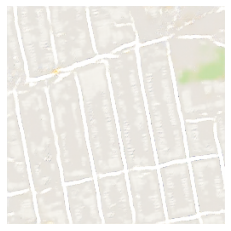

In [9]:
from keras.models import load_model

# load model
model = load_model('/content/drive/MyDrive/Strojno_projekt/models/model_054800.h5')
# generate image from source
gen_image = model.predict(src_image)
# scale from [-1,1] to [0,1]
gen_image = (gen_image + 1) / 2.0
# plot the image
pyplot.imshow(gen_image[0])
pyplot.axis('off')
pyplot.show()